In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import random
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
import numpy.linalg as la
from Policy import Policy

# REINFORCE Algorithm

In [2]:
def get_trajectory(env, episode_length):
    states = np.zeros(episode_length+1, dtype=int)
    actions = np.zeros(episode_length, dtype=int)
    rewards = np.zeros(episode_length, dtype=int)
    x, y = env.reset()
    states[0] = x * 5 + y
    for i in range(episode_length):
        action = env.action()
        observation, reward, done, info = env.step(action)
        states[i+1] = observation[0] * 5 + observation[1]
        actions[i] = action
        rewards[i] = reward
    return states, actions, rewards

def gradient(s, a, policy):
    dJ = np.zeros(policy.shape)
    p_action = np.exp(policy[s][a]) / np.sum(np.exp(policy[s]))
    dJ[s][:] = -p_action
    dJ[s][a] = 1 - p_action
    return dJ

In [3]:
def REINFORCE(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    for n in range(n_episode):
        reward_sum = 0
        policy = env.get_policy()
        dJ_all = np.zeros(policy.shape)
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ += gradient(states[e], actions[e], policy)
            dJ_all += dJ * rewards.sum() / num_trajectories
            reward_sum += rewards.sum() / num_trajectories
        env.update(learning_rate * dJ_all)
        reward_array.append(reward_sum / episode_length)
    return episode_array, reward_array

# REINFORCE Algorithm with Importance Sampling

In [4]:
# pool = [[policy, [[dJ_sum, states, actions, rewards], ...num_trajectories], ...n_episode]
def REINFORCE_Importance(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate, add_trajectories):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    pool = []
    var_old = []
    var_new = []
    for n in range(n_episode):
        policy = env.get_policy()
        origin_dJ_all = np.zeros(policy.shape)
        dJ_all = np.zeros(policy.shape)
        reward_sum = 0
        old_var = 0
        old_var_all = 0
        new_var = 0
        new_var_all = 0
        old_trajectories = len(pool) * num_trajectories
        real_add_trajectories = min(old_trajectories, add_trajectories)
        actual_trajectories = num_trajectories + real_add_trajectories
        pool.append([policy, []])
        if (old_trajectories != 0):
            index = np.random.choice(range(old_trajectories), real_add_trajectories, replace=False)
            for t in range(real_add_trajectories):
                index_episode = int(index[t] / num_trajectories)
                index_trajectory = index[t] % num_trajectories
                old_policy = pool[index_episode][0]
                dJ_sum, states, actions, rewards = pool[index_episode][1][index_trajectory]
                total_weight_numerator, total_weight_denominator = 0, 0
                for e in range(episode_length):
                    total_weight_numerator += policy[states[e]][actions[e]]
                    total_weight_denominator += old_policy[states[e]][actions[e]]
                total_weight = total_weight_numerator / total_weight_denominator
                reward_sum += total_weight * rewards.sum() / actual_trajectories
                new_var += (total_weight * la.norm(dJ_sum) * rewards.sum())**2 / actual_trajectories
                dJ_all += total_weight * dJ_sum * rewards.sum() / actual_trajectories
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ_sum = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ_sum += gradient(states[e], actions[e], policy)
            pool[n][1].append([dJ_sum, states, actions, rewards])
            origin_dJ_all += dJ_sum * rewards.sum() / num_trajectories
            dJ_all += dJ_sum * rewards.sum() / actual_trajectories
            old_var += (la.norm(dJ_sum) * rewards.sum())**2 / num_trajectories
            new_var += (la.norm(dJ_sum) * rewards.sum())**2 / actual_trajectories
            reward_sum += rewards.sum() / actual_trajectories
        old_var_all = old_var - la.norm(origin_dJ_all)**2
        new_var_all = new_var - la.norm(dJ_all)**2
        env.update(learning_rate * dJ_all)
        reward_array.append(reward_sum / episode_length)
        var_old.append(old_var_all)
        var_new.append(new_var_all)
    return episode_array, reward_array, var_old, var_new

# REINFORCE Algorithm with Causality

In [5]:
def REINFORCE_Causality(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    var_old = []
    var_new = []
    for n in range(n_episode):
        reward_sum = 0
        policy = env.get_policy()
        origin_dJ_all = np.zeros(policy.shape)
        dJ_all = np.zeros(policy.shape)
        old_var = 0
        old_var_all = 0
        new_var = 0
        new_var_all = 0
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            origin_dJ = np.zeros(policy.shape)
            dJ = np.zeros(policy.shape)
            for e in range(episode_length):
                origin_dJ += gradient(states[e], actions[e], policy)
                dJ += gradient(states[e], actions[e], policy) * rewards[e:episode_length].sum()
            origin_dJ_all += origin_dJ * rewards.sum() / num_trajectories
            old_var += (la.norm(origin_dJ) * rewards.sum())**2 / num_trajectories
            dJ_all += dJ / num_trajectories
            new_var += la.norm(dJ)**2 / num_trajectories
            reward_sum += rewards.sum() / num_trajectories
        old_var_all = old_var - la.norm(origin_dJ_all)**2
        new_var_all = new_var - la.norm(dJ_all)**2
        env.update(learning_rate * dJ_all)
        reward_array.append(reward_sum / episode_length)
        var_old.append(old_var_all)
        var_new.append(new_var_all)
    return episode_array, reward_array, var_old, var_new

# REINFORCE Algorithm with Baseline Shift

In [6]:
def REINFORCE_Baseline(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    var_old = []
    var_new = []
    for n in range(n_episode):
        reward_sum = 0
        policy = env.get_policy()
        dJ_all = np.zeros(policy.shape)
        b_numerator = 0
        b_denominator = 0
        old_var = 0
        old_var_all = 0
        new_var = 0
        new_var_all = 0
        records = []
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ += gradient(states[e], actions[e], policy)
            records.append([dJ, rewards])
            dJ_all += dJ * rewards.sum() / num_trajectories
            old_var += (la.norm(dJ) * rewards.sum())**2 / num_trajectories
            reward_sum += rewards.sum() / num_trajectories
            b_numerator += la.norm(dJ)**2 * rewards.sum() / num_trajectories
            b_denominator += la.norm(dJ)**2 / num_trajectories
        b = b_numerator / b_denominator
        old_var_all = old_var - la.norm(dJ_all)**2
        dJ_all_b = np.zeros(policy.shape)
        for t in range(num_trajectories):
            dJ_b = records[t][0]
            reward_b = records[t][1].sum() - b
            dJ_all_b += dJ_b * reward_b / num_trajectories
            new_var += (la.norm(dJ_b) * reward_b)**2 / num_trajectories
        new_var_all = new_var - la.norm(dJ_all_b)**2
        env.update(learning_rate * dJ_all_b)
        reward_array.append(reward_sum / episode_length)
        var_old.append(old_var_all)
        var_new.append(new_var_all)
    return episode_array, reward_array, var_old, var_new

# Learning Curves and Sample Variance

## Easy

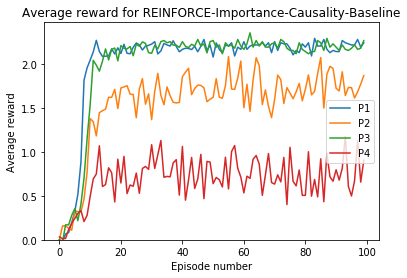

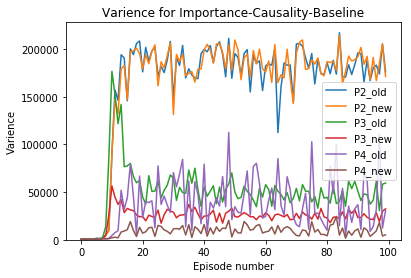

In [7]:
# level, epsilon, episode_length, num_trajectories, n_episode, learning_rate
r_episode_1, r_reward_1 = REINFORCE('easy', 0.1, 20, 20, 100, 0.1)
r_episode_2, r_reward_2, var_old_2, var_new_2 = REINFORCE_Importance('easy', 0.1, 20, 20, 100, 0.1, 5)
r_episode_3, r_reward_3, var_old_3, var_new_3 = REINFORCE_Causality('easy', 0.1, 20, 20, 100, 0.1)
r_episode_4, r_reward_4, var_old_4, var_new_4 = REINFORCE_Baseline('easy', 0.1, 20, 20, 100, 0.1)

plt.figure(1)
plt.title('Average reward for REINFORCE-Importance-Causality-Baseline')
plt.plot(r_episode_1, r_reward_1, label='P1')
plt.plot(r_episode_2, r_reward_2, label='P2')
plt.plot(r_episode_3, r_reward_3, label='P3')
plt.plot(r_episode_4, r_reward_4, label='P4')
plt.xlabel('Episode number')
plt.ylabel('Average reward')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.figure(2)
plt.title('Varience for Importance-Causality-Baseline')
plt.plot(r_episode_2, var_old_2, label='P2_old')
plt.plot(r_episode_2, var_new_2, label='P2_new')
plt.plot(r_episode_3, var_old_3, label='P3_old')
plt.plot(r_episode_3, var_new_3, label='P3_new')
plt.plot(r_episode_4, var_old_4, label='P4_old')
plt.plot(r_episode_4, var_new_4, label='P4_new')
plt.xlabel('Episode number')
plt.ylabel('Varience')
plt.ylim(bottom=0)
plt.legend()
plt.show()

## Hard

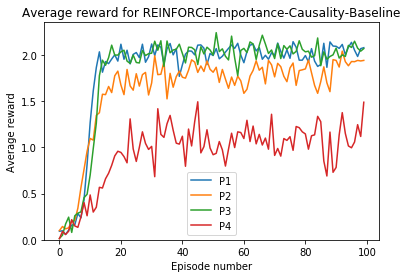

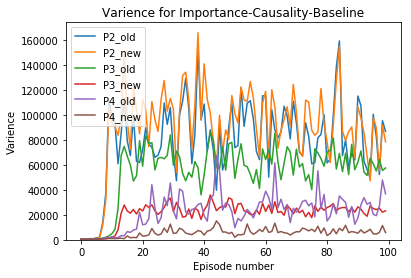

In [8]:
# level, epsilon, episode_length, num_trajectories, n_episode, learning_rate
r_episode_1, r_reward_1 = REINFORCE('hard', 0.1, 20, 20, 100, 0.1)
r_episode_2, r_reward_2, var_old_2, var_new_2 = REINFORCE_Importance('hard', 0.1, 20, 20, 100, 0.1, 5)
r_episode_3, r_reward_3, var_old_3, var_new_3 = REINFORCE_Causality('hard', 0.1, 20, 20, 100, 0.1)
r_episode_4, r_reward_4, var_old_4, var_new_4 = REINFORCE_Baseline('hard', 0.1, 20, 20, 100, 0.1)

plt.figure(1)
plt.title('Average reward for REINFORCE-Importance-Causality-Baseline')
plt.plot(r_episode_1, r_reward_1, label='P1')
plt.plot(r_episode_2, r_reward_2, label='P2')
plt.plot(r_episode_3, r_reward_3, label='P3')
plt.plot(r_episode_4, r_reward_4, label='P4')
plt.xlabel('Episode number')
plt.ylabel('Average reward')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.figure(2)
plt.title('Varience for Importance-Causality-Baseline')
plt.plot(r_episode_2, var_old_2, label='P2_old')
plt.plot(r_episode_2, var_new_2, label='P2_new')
plt.plot(r_episode_3, var_old_3, label='P3_old')
plt.plot(r_episode_3, var_new_3, label='P3_new')
plt.plot(r_episode_4, var_old_4, label='P4_old')
plt.plot(r_episode_4, var_new_4, label='P4_new')
plt.xlabel('Episode number')
plt.ylabel('Varience')
plt.ylim(bottom=0)
plt.legend()
plt.show()

## Conclusion

We can see that "causality" and "baseline shift" reduce the sample variance, while the "importance sampling" don't reduce.

# Ablation Study

## Importance Sampling and Causality

In [10]:
# pool = [[policy, [[dJ_sum, states, actions, rewards], ...num_trajectories], ...n_episode]
def Importance_Causality(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate, add_trajectories):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    pool = []
    for n in range(n_episode):
        policy = env.get_policy()
        dJ_all = np.zeros(policy.shape)
        reward_sum = 0
        old_trajectories = len(pool) * num_trajectories
        real_add_trajectories = min(old_trajectories, add_trajectories)
        actual_trajectories = num_trajectories + real_add_trajectories
        pool.append([policy, []])
        if (old_trajectories != 0):
            index = np.random.choice(range(old_trajectories), real_add_trajectories, replace=False)
            for t in range(real_add_trajectories):
                index_episode = int(index[t] / num_trajectories)
                index_trajectory = index[t] % num_trajectories
                old_policy = pool[index_episode][0]
                dJ_sum, states, actions, rewards = pool[index_episode][1][index_trajectory]
                total_weight_numerator, total_weight_denominator = 0, 0
                for e in range(episode_length):
                    total_weight_numerator += policy[states[e]][actions[e]]
                    total_weight_denominator += old_policy[states[e]][actions[e]]
                total_weight = total_weight_numerator / total_weight_denominator
                reward_sum += total_weight * rewards.sum() / actual_trajectories
                dJ_all += total_weight * dJ_sum / actual_trajectories
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ_sum = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ_sum += gradient(states[e], actions[e], policy) * rewards[e:episode_length].sum()
            pool[n][1].append([dJ_sum, states, actions, rewards])
            dJ_all += dJ_sum / actual_trajectories
            reward_sum += rewards.sum() / actual_trajectories
        env.update(learning_rate * dJ_all)
        reward_array.append(reward_sum / episode_length)
    return episode_array, reward_array

## Causality and Baseline Shift

In [38]:
def Causality_Baseline(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    for n in range(n_episode):
        reward_sum = 0
        policy = env.get_policy()
        b_numerator = 0
        b_denominator = 0
        records = []
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ += gradient(states[e], actions[e], policy)
            records.append([states, actions, rewards])
            reward_sum += rewards.sum() / num_trajectories
            b_numerator += la.norm(dJ)**2 * rewards.sum() / num_trajectories
            b_denominator += la.norm(dJ)**2 / num_trajectories
        b = b_numerator / b_denominator
        dJ_all_b = np.zeros(policy.shape)
        for t in range(num_trajectories):
            states_b, actions_b, rewards_b = records[t][0], records[t][1], records[t][2]
            dJ_b = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ_b += gradient(states_b[e], actions_b[e], policy) * (rewards_b[e:episode_length].sum() - b)
            dJ_all_b += dJ_b / num_trajectories
        env.update(learning_rate * dJ_all_b)
        reward_array.append(reward_sum / episode_length)
    return episode_array, reward_array

## Importance Sampling and Baseline Shift

In [42]:
# pool = [[policy, [[dJ_sum, states, actions, rewards], ...num_trajectories], ...n_episode]
def Importance_Baseline(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate, add_trajectories):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    pool = []
    for n in range(n_episode):
        policy = env.get_policy()
        reward_sum = 0
        old_trajectories = len(pool) * num_trajectories
        real_add_trajectories = min(old_trajectories, add_trajectories)
        actual_trajectories = num_trajectories + real_add_trajectories
        pool.append([policy, []])
        b_numerator = 0
        b_denominator = 0
        records = []
        if (old_trajectories != 0):
            index = np.random.choice(range(old_trajectories), real_add_trajectories, replace=False)
            for t in range(real_add_trajectories):
                index_episode = int(index[t] / num_trajectories)
                index_trajectory = index[t] % num_trajectories
                old_policy = pool[index_episode][0]
                dJ_sum, states, actions, rewards = pool[index_episode][1][index_trajectory]
                total_weight_numerator, total_weight_denominator = 0, 0
                for e in range(episode_length):
                    total_weight_numerator += policy[states[e]][actions[e]]
                    total_weight_denominator += old_policy[states[e]][actions[e]]
                total_weight = total_weight_numerator / total_weight_denominator
                reward_sum += total_weight * rewards.sum() / actual_trajectories
                records.append([total_weight * dJ_sum, rewards])
                b_numerator += la.norm(total_weight * dJ_sum)**2 * rewards.sum() / num_trajectories
                b_denominator += la.norm(total_weight * dJ_sum)**2 / num_trajectories
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ_sum = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ_sum += gradient(states[e], actions[e], policy) * rewards[e:episode_length].sum()
            pool[n][1].append([dJ_sum, states, actions, rewards])
            records.append([dJ_sum, rewards])
            b_numerator += la.norm(dJ_sum)**2 * rewards.sum() / num_trajectories
            b_denominator += la.norm(dJ_sum)**2 / num_trajectories
            reward_sum += rewards.sum() / actual_trajectories
        b = b_numerator / b_denominator
        dJ_all_b = np.zeros(policy.shape)
        for t in range(actual_trajectories):
            dJ_b = records[t][0]
            reward_b = records[t][1].sum() - b
            dJ_all_b += dJ_b * reward_b / actual_trajectories
        env.update(learning_rate * dJ_all_b)
        reward_array.append(reward_sum / episode_length)
    return episode_array, reward_array

## Comparison

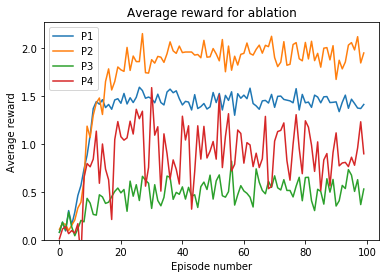

In [50]:
# level, epsilon, episode_length, num_trajectories, n_episode, learning_rate
r_episode_1, r_reward_1 = REINFORCE('hard', 0.1, 20, 20, 100, 0.1)
r_episode_2, r_reward_2 = Importance_Causality('hard', 0.1, 20, 20, 100, 0.1, 5)
r_episode_3, r_reward_3 = Causality_Baseline('hard', 0.1, 20, 20, 100, 0.1)
r_episode_4, r_reward_4 = Importance_Baseline('hard', 0.1, 20, 20, 100, 0.1, 5)

plt.figure(1)
plt.title('Average reward for ablation')
plt.plot(r_episode_1, r_reward_1, label='P1')
plt.plot(r_episode_2, r_reward_2, label='P2')
plt.plot(r_episode_3, r_reward_3, label='P3')
plt.plot(r_episode_4, r_reward_4, label='P4')
plt.xlabel('Episode number')
plt.ylabel('Average reward')
plt.ylim(bottom=0)
plt.legend()
plt.show()